- Encoder: represent input sequences <br>
- Decoder: generate target sequences

### Positionwise Feed-Forward Networks

In [1]:
import math

import torch
from d2l import torch as d2l
from torch import nn

In [2]:
class PositionWiseFFN(nn.Module):
    """The positionwise feed-forward network."""

    def __init__(self, ffn_num_hiddens, ffn_num_outputs):
        super().__init__()
        self.dense1 = nn.LazyLinear(ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.LazyLinear(ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [3]:
ffn_num_hiddens = 3
ffn_num_outputs = 8

ffn = PositionWiseFFN(ffn_num_hiddens, ffn_num_outputs)
ffn.eval()

input_embeddings = torch.tensor([1., 2, 3, 4]).repeat(2, 1)
print(f'input_embeddings:\n{input_embeddings}')
print(f'ffn(input_embeddings):\n{ffn(input_embeddings)}')

input_embeddings:
tensor([[1., 2., 3., 4.],
        [1., 2., 3., 4.]])
ffn(input_embeddings):
tensor([[-0.0642, -0.5468,  0.0207,  0.3787, -0.8244, -0.0629,  0.0819, -0.2118],
        [-0.0642, -0.5468,  0.0207,  0.3787, -0.8244, -0.0629,  0.0819, -0.2118]],
       grad_fn=<AddmmBackward0>)


C:\Users\billt\PycharmProjects\DeepLearning\dl_venv\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [4]:
ffn.dense1.weight.shape, ffn.dense2.weight.shape, 

(torch.Size([3, 4]), torch.Size([8, 3]))

**REMARK**. Number of hidden units or feature dimension in the input is not the same as the ```ffn_num_hiddens```. ```nn.LazyLinear``` can infer the ```in_features ```. In the above example, the input has shape: (2, 4) and ffn.dense1.weight has shape (3, 4).

### nn.linear

In nn.linear, a linear transformation is applied to the incoming data:
\begin{equation}
    y = xA^{T} + b.
\end{equation}

In [5]:
x = torch.tensor([1., 2, 3, 4])
ff_outputs = ffn(x)

In [6]:
x

tensor([1., 2., 3., 4.])

In [7]:
ff_outputs

tensor([-0.0642, -0.5468,  0.0207,  0.3787, -0.8244, -0.0629,  0.0819, -0.2118],
       grad_fn=<AddBackward0>)

In [8]:
ffn.dense1._parameters

OrderedDict([('weight',
              Parameter containing:
              tensor([[-0.3014, -0.4514, -0.1196,  0.2605],
                      [-0.0927, -0.4475,  0.1962,  0.2381],
                      [-0.3941, -0.3836,  0.2110, -0.1571]], requires_grad=True)),
             ('bias',
              Parameter containing:
              tensor([-0.4119,  0.1695,  0.3040], requires_grad=True))])

In [9]:
W1, b1 = ffn.dense1._parameters['weight'], ffn.dense1._parameters['bias']
W2, b2 = ffn.dense2._parameters['weight'], ffn.dense2._parameters['bias']

In [10]:
tmp = ffn.relu(x @ W1.T + b1)
tmp @ W2.T + b2

tensor([-0.0642, -0.5468,  0.0207,  0.3787, -0.8244, -0.0629,  0.0819, -0.2118],
       grad_fn=<AddBackward0>)

Note that a feed-forward layer such as nn.Linear is usually applied to a tensor of shape (batch_size, input_dim), where it acts on each element of the batch independently. <br> This is actually true for any dimension **except the last one, so when we pass a tensor of shape (batch_size, seq_len, hidden_dim) the layer is applied to all token embeddings of the batch and sequence independently**.

In [11]:
batch_size = 2
num_steps = 3
num_hiddens = 4
num_outputs = 8
ffn = PositionWiseFFN(num_hiddens, num_outputs)
ffn.eval()

PositionWiseFFN(
  (dense1): LazyLinear(in_features=0, out_features=4, bias=True)
  (relu): ReLU()
  (dense2): LazyLinear(in_features=0, out_features=8, bias=True)
)

In [12]:
input_embeddings = torch.ones((batch_size, num_steps, num_hiddens))
input_embeddings

tensor([[[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]]])

In [13]:
ffn(input_embeddings)

tensor([[[-0.2079, -0.3091,  0.0290, -0.0489, -0.4492,  0.0486,  0.1026,
           0.6837],
         [-0.2079, -0.3091,  0.0290, -0.0489, -0.4492,  0.0486,  0.1026,
           0.6837],
         [-0.2079, -0.3091,  0.0290, -0.0489, -0.4492,  0.0486,  0.1026,
           0.6837]],

        [[-0.2079, -0.3091,  0.0290, -0.0489, -0.4492,  0.0486,  0.1026,
           0.6837],
         [-0.2079, -0.3091,  0.0290, -0.0489, -0.4492,  0.0486,  0.1026,
           0.6837],
         [-0.2079, -0.3091,  0.0290, -0.0489, -0.4492,  0.0486,  0.1026,
           0.6837]]], grad_fn=<ViewBackward0>)

![input_emb](figure/input_emb.png)

### Review: Batch Normalization/批量归一化

1. A popular and effective technique that consistently **accelerates the convergence** of deep networks.
2. Together with **residual blocks** batch normalization has 
made it possible for practitioners to routinely train networks with **over 100 layers**.

Denote by $\mathcal{B}$ a minibatch and let $x \in \mathcal{B}$ be an input to batch normalization (BN). In this case the batch normalization is defined as follows:
\begin{equation}
    BN(x) = \gamma \odot \frac{x - \hat{\mu}_\mathcal{B}}{\hat{\sigma}_\mathcal{B}} + \beta,
\end{equation}
where $\odot$ is the elementwise product.

- $\hat{\mu}_\mathcal{B}$ is the sample mean, $\hat{\sigma}_\mathcal{B}$ the sample standard deviation of the minibatch $\mathcal{B}$.
- Scale parameter $\gamma$ and shift parameter $\beta$ that have the **same shape** as $x$.
- Both are parameters that need to be **learned** as part of model training. Motivation: "simply normalizing each input of a layer may
change what the layer can represent...To address this, we make sure that the transformation inserted in the network can represent the **identity transform**." [Ioffe and Szegedy, 2015, page 3](https://arxiv.org/pdf/1502.03167.pdf)
- Fully connected layers. We can express the computation of a batch-normalizationenabled, fully connected layer output $h$ as follows
\begin{equation}
    h = \phi{(BN(Wx+b))}.
\end{equation}
- <font color='red'>After</font> **training**, we use **the entire dataset** to compute stable estimates of the variable statistics and then fix them <font color='red'>at the prediction time</font>: We store $(\mu_{batch}, \sigma^2_{batch})$ for every mini-batch in every layer of the network:
\begin{equation}
\begin{aligned}
    \mu_{test} &= \mathbb{E}(\mu_{batch}) \\
    \sigma^2_{test} &= \frac{m}{m-1}\mathbb{E}(\sigma^2_{batch}).
\end{aligned}
\end{equation}
For inference, we use the normalization:
\begin{equation}
    BN(x_{test}) = \gamma \odot \frac{x - \hat{\mu}_{test}}{\hat{\sigma}_{test}} + \beta.
\end{equation}
Like dropout regularization, the noise is only injected during training.
- When applying batch normalization, the choice of **batch size** is even more significant than without batch normalization. Batch normalization has connection to Bayesian priors and penalties. The method works best for moderate minibatches sizes in the 50 to 100 range. A larger minibatch regularizes less due to the more stable estimates, whereas tiny minibatches destroy useful signal due to high variance.

### Layer Normalization/层归一化

**Layer normalization** is the same as batch normalization except that the former normalizes **across the feature dimension**, thus
enjoying benefits of scale independence and batch size independence.

In [14]:
ln = nn.LayerNorm(2)
bn = nn.LazyBatchNorm1d()
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)

The resulting normalized tensors from differnt methods

In [15]:
print('layer norm:', ln(X))  #  the mean of each ROW is 0, and the standard deviation is 1.

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>)


In [16]:
print('batch norm:', bn(X))  #  the mean of each COLUMN is 0, and the standard deviation is 1.

batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


### nn.LayerNorm

The mean and standard-deviation are calculated over the last $D$ dimensions, where $D$ is the length of ```normalized_shape```. <br>
For example, if ```normalized_shape``` is (3,2) (a 2-dimensional shape), the mean and standard-deviation are computed over the last 2 dimensions of the input.

normalized_shape (int or list or torch.Size) – input shape from an expected input of size <br>
```[normalized_shape[0]×normalized_shape[1]×…×normalized_shape[−1]]``` <br>
If a single integer is used, it is treated as a singleton list, and this module will normalize over the last dimension which is expected to be of that specific size.

### Compare of batch normalization and layer normalization

Suppose the input is 2-dimensional.

![comp_bn_ln](figure/comp_bn_ln.png)

When we have 3d input:

![ln_3d](figure/ln_3d.png)

Why layer normalization works?

![why_ln](figure/why_ln.png)

### Residual Connection

The residual connection requires that the **two inputs are of the same shape** so that the output
tensor also has the same shape after the addition operation.

In [17]:
class AddNorm(nn.Module):
    """The residual connection followed by layer normalization."""

    def __init__(self, norm_shape, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(norm_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [18]:
add_norm = AddNorm(num_hiddens, dropout=0.5)
shape = (batch_size, num_steps, num_hiddens)
d2l.check_shape(add_norm(torch.ones(shape), torch.ones(shape)), shape)
print(add_norm(torch.ones(shape), torch.ones(shape)))

tensor([[[ 1.0000,  1.0000, -1.0000, -1.0000],
         [ 0.5773,  0.5773, -1.7320,  0.5773],
         [ 0.5773,  0.5773, -1.7320,  0.5773]],

        [[ 1.0000, -1.0000,  1.0000, -1.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [-1.7320,  0.5773,  0.5773,  0.5773]]],
       grad_fn=<NativeLayerNormBackward0>)


### Encoder

![transformer](figure/transformer.png)

TransformerEncoderBlock class contains two sublayers sublayers: 
1. multi-head self-attention,
2. positionwise feed-forward networks.

Start with a **single layer** within the encoder.

In [19]:
class TransformerEncoderBlock(nn.Module):
    """The Transformer encoder block."""

    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout,
                 use_bias=False):
        super().__init__()
        self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                dropout, use_bias)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(num_hiddens, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [20]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = TransformerEncoderBlock(24, 48, 8, 0.5)
encoder_blk.eval()
d2l.check_shape(encoder_blk(X, valid_lens), X.shape)

**REMARK**. Any layer in the Transformer encoder does not change the shape of its input.

Next we stack num_blks instances of the above TransformerEncoderBlock classes.

In [21]:
class TransformerEncoder(d2l.Encoder):
    """The Transformer encoder."""

    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_blks, dropout, use_bias=False):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block" + str(i), TransformerEncoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias))

    def forward(self, X, valid_lens):
        # Since positional encoding values are between -1 and 1, the embedding
        # values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

### TransformerEncoder

```X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))```
Since the self-attention does not preserve the order of the sequence, we use a fixed positional encodings.

In [22]:
batch_size, num_steps = 2, 100
vocab_size, num_hiddens, ffn_num_hiddens, num_heads, num_blks = 200, 24, 48, 8, 3
encoder = TransformerEncoder(vocab_size, num_hiddens, ffn_num_hiddens, num_heads, num_blks, dropout=0.5)
d2l.check_shape(encoder(torch.ones((batch_size, num_steps), dtype=torch.long), valid_lens),
                (batch_size, num_steps, num_hiddens))

In [23]:
encoder

TransformerEncoder(
  (embedding): Embedding(200, 24)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (blks): Sequential(
    (block0): TransformerEncoderBlock(
      (attention): MultiHeadAttention(
        (attention): DotProductAttention(
          (dropout): Dropout(p=0.5, inplace=False)
        )
        (W_q): Linear(in_features=24, out_features=24, bias=False)
        (W_k): Linear(in_features=24, out_features=24, bias=False)
        (W_v): Linear(in_features=24, out_features=24, bias=False)
        (W_o): Linear(in_features=24, out_features=24, bias=False)
      )
      (addnorm1): AddNorm(
        (dropout): Dropout(p=0.5, inplace=False)
        (ln): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
      )
      (ffn): PositionWiseFFN(
        (dense1): Linear(in_features=24, out_features=48, bias=True)
        (relu): ReLU()
        (dense2): Linear(in_features=48, out_features=24, bias=True)
      )
      (addnorm2): AddNorm(
   

In [24]:
encoder.blks[0].ffn

PositionWiseFFN(
  (dense1): Linear(in_features=24, out_features=48, bias=True)
  (relu): ReLU()
  (dense2): Linear(in_features=48, out_features=24, bias=True)
)

In [25]:
encoder.blks[0].ffn.dense1.weight

Parameter containing:
tensor([[-0.0546, -0.0903, -0.1662,  ..., -0.0955,  0.1037,  0.1220],
        [-0.1980, -0.0120, -0.0784,  ..., -0.1902,  0.0495, -0.0177],
        [-0.0157, -0.1085,  0.1061,  ..., -0.0722, -0.0586,  0.1190],
        ...,
        [ 0.0656, -0.1996,  0.1478,  ..., -0.0594,  0.1731, -0.0489],
        [ 0.0380, -0.0605, -0.0638,  ...,  0.0676,  0.0438,  0.1437],
        [ 0.1231, -0.1374, -0.0361,  ...,  0.0581, -0.0476,  0.0843]],
       requires_grad=True)

### Dimensionality

```X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))```
1. The input X has shape: (2, 100)
2. The embedded input ```embedding(X)``` has shape: (2, 100, 24)
3. The positional encodded input ```self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))``` has shape: (2, 100, 24). Again, the positional encoding does not change the shape.

### Decoder

TransformerDecoderBlock class contains three sublayers: 
1. decoder self-attention,
2. **encoder-decoder attention**,
3. positionwise 
feed-forward networks.

In [26]:
class TransformerDecoderBlock(nn.Module):
    # The i-th block in the Transformer decoder
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, i):
        super().__init__()
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.attention2 = d2l.MultiHeadAttention(num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(num_hiddens, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # During training, all the tokens of any output sequence are processed
        # at the same time, so state[2][self.i] is None as initialized. When
        # decoding any output sequence token by token during prediction,
        # state[2][self.i] contains representations of the decoded output at
        # the i-th block up to the current time step
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), dim=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # Shape of dec_valid_lens: (batch_size, num_steps), where every
            # row is [1, 2, ..., num_steps]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
        # Self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)  # Shape of Y: (batch_size, num_steps, num_hiddens)
        # Encoder-decoder attention. Shape of enc_outputs:
        # (batch_size, num_steps, num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

For each decoder block, we compute 
1. ```Y = self.addnorm1(X, X2)```: multihead self-attention + the residual connection followed by layer normalization. Recall that in ```AddNorm```, we do ```self.ln(self.dropout(Y) + X)```. 
2. ```self.addnorm2(Y, self.ffn(Y))```: The residual connection followed by layer normalization + positionwise FFN
3. ```Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)```: enc_outputs as keys and values, and Y from decoder as query.
4. if self.training: dec_valid_lens = torch.arange(1, num_steps + 1, device=X.device).repeat(batch_size, 1)
6. if state[2][self.i] is None:
       key_values = X
   else:
       key_values = torch.cat((state[2][self.i], X), dim=1)
   ```if state[2][self.i] is None``` corresponds to the training stage. For inference, keys are the enc dec inputs up to the current timestep. 

**REMARK**. The number of encoder bloks does not need to equal to the number of decoder blocks.

In [ ]:
class EncoderDecoder(d2l.Classifier):
    """The base class for the encoder--decoder architecture.

    Defined in :numref:`sec_encoder-decoder`"""
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_all_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_all_outputs, *args)
        # Return decoder output only
        return self.decoder(dec_X, dec_state)[0]

    def predict_step(self, batch, device, num_steps,
                     save_attention_weights=False):
        """Defined in :numref:`sec_seq2seq_training`"""
        batch = [d2l.to(a, device) for a in batch]
        src, tgt, src_valid_len, _ = batch
        enc_all_outputs = self.encoder(src, src_valid_len)
        dec_state = self.decoder.init_state(enc_all_out        outputs, attention_weights = [d2l.expand_dims(tgt[:, 0], 1), ], []
[0]}')
        quit()

        for _ in range(num_steps):
            Y, dec_state = self.decoder(outputs[-1], dec_state)
            outputs.append(d2l.argmax(Y, 2))
            # Save attention weights (to be covered later)
            if save_attention_weights:
                attention_weights.append(self.decoder.attention_weights)
        return d2l.concat(outputs[1:], 1), attention_weights

1. ```outputs=[d2l.expand_dims(tgt[:, 0], 1), ]```, outputs: [tensor([[3], [3]  [3     [3]], device='cuda, a list of 3 whose length equals to the number of tokens in the decoder inputs, where 3 corresponds to the index of <bos>.:0')] 

In [27]:
num_hiddens, ffn_num_hiddens, num_heads = 24, 48, 8
block_idx = 0
decoder_blk = TransformerDecoderBlock(num_hiddens, ffn_num_hiddens, num_heads, dropout=0.5, i=block_idx)
X = torch.ones((batch_size, num_steps, num_hiddens))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
d2l.check_shape(decoder_blk(X, state)[0], X.shape)

### state

```state = [encoder_blk(X, valid_lens), valid_lens, [None]]``` <br>
The state contains 3 components: 
1. encoded output,
2. valid lengths,
3. the representations of the decoded output up to the current time step.

### TransformerDecoderBlock.forward 

1. Self-attention <br>
In **inference**, ```key_values``` is ```X``` or the cumulative X up to the current timestep. <br> 
X2 = self.attention1(X, key_values, key_values, dec_valid_lens) <br>
Y = self.addnorm1(X, X2) <br>
To justify that, we can print out ```dec_state[2][i]``` under the for loop in ```EncoderDecoder.predict_step```: <br>
dec_state[2][0].shape: torch.Size([4, 1, 256]) <br>
dec_state[2][0].shape: torch.Size([4, 2, 256])<br>
dec_state[2][0].shape: torch.Size([4, 3, 256]) <br>
dec_state[2][0].shape: torch.Size([4, 4, 256]) <br>
dec_state[2][0].shape: torch.Size([4, 5, 256]) <br>
dec_state[2][0].shape: torch.Size([4, 6, 256]) <br>
dec_state[2][0].shape: torch.Size([4, 7, 256]) <br>
dec_state[2][0].shape: torch.Size([4, 8, 256]) <br>
dec_state[2][0].shape: torch.Size([4, 9, 256]) <br>
```print(f'data.num_steps: {data.num_steps}')  # data.num_steps: 9``` <br>
dec_state[2][i] has shape: (num_pair_engs_fras, current_step, num_hiddens) <br>
2. **Encoder-decoder attention** <br>
Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens) <br>
Z = self.addnorm2(Y, Y2) <br>
3. positionwise feed-forward networks <br>
self.addnorm3(Z, self.ffn(Z)) <br>

In [28]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads, num_blks, dropout):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.num_blks = num_blks
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block" + str(i), TransformerDecoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, i))
        self.dense = nn.LazyLinear(vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens):
        return [enc_outputs, enc_valid_lens, [None] * self.num_blks]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range(2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # Decoder self-attention weights
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

### Training

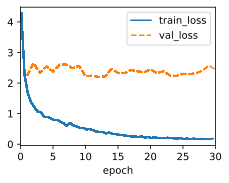

In [29]:
data = d2l.MTFraEng(batch_size=128)
num_hiddens, num_blks, dropout = 256, 2, 0.2
ffn_num_hiddens, num_heads = 64, 4
encoder = TransformerEncoder(
    len(data.src_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
decoder = TransformerDecoder(
    len(data.tgt_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.0015)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [30]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['il', 'est', 'mort', '.'], bleu,0.658
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


### Complexity

![input_emb](figure/complexity.png)

1. Recall that for the standard way of multiplying $Q_{n \times d}$ and $(K^T)_{d \times n}$ is $O(n^2d)$.
2. Sequential operations. How many previous steps need to be completed before the next calculation.
3. Maximum path length. How far does an information travel from one data point to another.